# Part 1 - Clustering of Text Data

## Question 1: Build TF-IDF Matrix

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

labels = [0 if label<4 else 1 for label in dataset.target]

print('X_tfidf Shape:', X_tfidf.shape)

X_tfidf Shape: (7882, 27768)


## Question 2: Contingency Table of K-means Clustering

In [2]:
from sklearn.cluster import KMeans

km_tfidf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
km_tfidf.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import contingency_matrix

actual_class_names=['Class 1', 'Class 2']
cluster_class_names=['Cluster 1', 'Cluster 2']

cm = contingency_matrix(labels, km_tfidf.labels_)

plt.imshow(cm, cmap=plt.cm.Greys)
plt.colorbar()
plt.xticks(range(len(actual_class_names)), actual_class_names)
plt.yticks(range(len(actual_class_names)), cluster_class_names)


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if np.argmax(cm) == i*cm.shape[1]+j:
            plt.text(j, i, cm[i, j], horizontalalignment="center", color='w')
        else:
            plt.text(j, i, cm[i, j], horizontalalignment="center", color='k')
            
plt.tight_layout()
plt.ylabel('Clustering Result')
plt.xlabel('Ground Truth')
plt.title('Contingency Table', fontweight='bold')
plt.show()
# plt.savefig('contingency_table.png')

<Figure size 640x480 with 2 Axes>

## Question 3: Five Measures for K-means Clustering

In [4]:
from sklearn import metrics

def report_clustering_measures(predicted_labels, true_labels):
    print("Homogeneity: %f" % metrics.homogeneity_score(true_labels, predicted_labels))
    print("Completeness: %f" % metrics.completeness_score(true_labels, predicted_labels))
    print("V-measure: %f" % metrics.v_measure_score(true_labels, predicted_labels))
    print("Adjusted Rand Index: %f" % metrics.adjusted_rand_score(true_labels, predicted_labels))
    print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(true_labels, predicted_labels))

In [5]:
report_clustering_measures(km_tfidf.labels_, labels)

Homogeneity: 0.255245
Completeness: 0.336064
V-measure: 0.290132
Adjusted Rand Index: 0.182710
Adjusted Mutual Information: 0.290058


## Question 4: Plot of Percentage of Variance Retained

In [6]:
from sklearn.decomposition import TruncatedSVD

r_max = 1000
svd = TruncatedSVD(n_components=r_max, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

variance_percent = [0] * len(svd.explained_variance_ratio_)
for i in range(len(svd.explained_variance_ratio_)):
    variance_percent[i] = sum(svd.explained_variance_ratio_[:i+1])

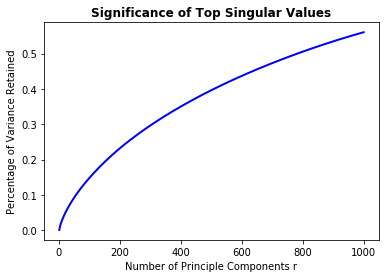

In [7]:
plt.plot(range(1, 1001, 1), variance_percent, linewidth=2, color='b')
plt.xlabel('Number of Principle Components r')
plt.ylabel('Percentage of Variance Retained')
plt.title('Significance of Top Singular Values', fontweight='bold')
plt.show()
# plt.savefig('percent_var.png')

## Question 5: Dimension Reduction Performance Comparisons Between PCA and NMF

In [8]:
def plot_measurement_score(method, measure, scores, r_categories = ['1','2','3','5','10','20','50','100','300']):
    fig, ax = plt.subplots()
    
    bars = plt.bar(r_categories, scores, facecolor='blue', alpha = 0.7, edgecolor='black', linewidth=1)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
        
    plt.xticks(r_categories)   
    plt.xlabel('Number of Principal Components r')
    plt.ylabel('Clustering Purity Metrics')
    #plt.title(measure+' Score', fontweight='bold')
    plt.ylim(0,0.85)
    plt.show()
    #plt.savefig('{}_{}.png'.format(method, measure.lower()))

### Principle Components Analysis (PCA)

In [9]:
import time

r_list = [1,2,3,5,10,20,50,100,300]

pca_homogeneity = []
pca_completeness = []
pca_v_measure = []
pca_adjusted_rand_index = []
pca_adjusted_mutual_info = []

for r in r_list:
    t1 = time.time()
    pca = TruncatedSVD(n_components=r, random_state=42)
    X_pca = pca.fit_transform(X_tfidf)
    
    
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    km.fit(X_pca)
    print('KMeans Clustering with PCA, r=%s, in %f seconds...' 
          % (r, (time.time()-t1)))
    
    pca_homogeneity.append(metrics.homogeneity_score(labels, km.labels_))
    pca_completeness.append(metrics.completeness_score(labels, km.labels_))
    pca_v_measure.append(metrics.v_measure_score(labels, km.labels_))
    pca_adjusted_rand_index.append(metrics.adjusted_rand_score(labels, km.labels_))
    pca_adjusted_mutual_info.append(metrics.adjusted_mutual_info_score(labels, km.labels_))

KMeans Clustering with PCA, r=1, in 0.269413 seconds...
KMeans Clustering with PCA, r=2, in 0.378570 seconds...
KMeans Clustering with PCA, r=3, in 0.447982 seconds...
KMeans Clustering with PCA, r=5, in 0.377523 seconds...
KMeans Clustering with PCA, r=10, in 0.524853 seconds...
KMeans Clustering with PCA, r=20, in 0.745908 seconds...
KMeans Clustering with PCA, r=50, in 1.458957 seconds...
KMeans Clustering with PCA, r=100, in 2.784847 seconds...
KMeans Clustering with PCA, r=300, in 8.143407 seconds...


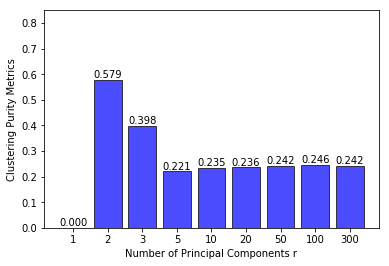

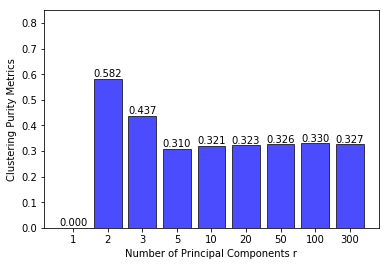

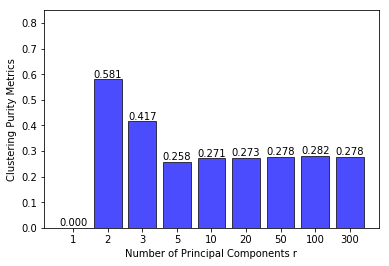

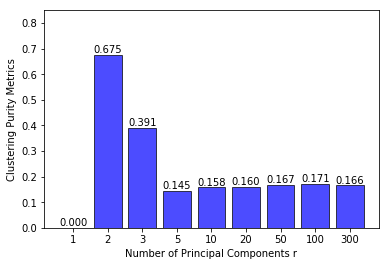

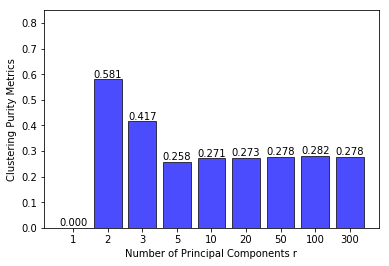

In [10]:
pca_measure_scores = [(pca_homogeneity, 'Homogeneity'), (pca_completeness, 'Completeness'), 
                      (pca_v_measure, 'V-measure'), (pca_adjusted_rand_index, 'Adjusted Rand Index'), 
                      (pca_adjusted_mutual_info, 'Adjusted Mutual Information')]

for score, measure in pca_measure_scores:
    plot_measurement_score('pca', measure, score)

### Non-Negative Matrix Factorization (NMF)

In [11]:
from sklearn.decomposition import NMF

nmf_homogeneity = []
nmf_completeness = []
nmf_v_measure = []
nmf_adjusted_rand_index = []
nmf_adjusted_mutual_info = []

for r in r_list:
    t1 = time.time()
    nmf = NMF(n_components=r, random_state=42)
    X_nmf = nmf.fit_transform(X_tfidf)
    
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    km.fit(X_nmf)
    print('KMeans Clustering with NMF, r=%s, in %f seconds...' 
          % (r, (time.time()-t1)))
    
    nmf_homogeneity.append(metrics.homogeneity_score(labels, km.labels_))
    nmf_completeness.append(metrics.completeness_score(labels, km.labels_))
    nmf_v_measure.append(metrics.v_measure_score(labels, km.labels_))
    nmf_adjusted_rand_index.append(metrics.adjusted_rand_score(labels, km.labels_))
    nmf_adjusted_mutual_info.append(metrics.adjusted_mutual_info_score(labels, km.labels_))

KMeans Clustering with NMF, r=1, in 0.325714 seconds...
KMeans Clustering with NMF, r=2, in 0.831075 seconds...
KMeans Clustering with NMF, r=3, in 0.979327 seconds...
KMeans Clustering with NMF, r=5, in 0.929385 seconds...
KMeans Clustering with NMF, r=10, in 3.234171 seconds...
KMeans Clustering with NMF, r=20, in 8.418683 seconds...
KMeans Clustering with NMF, r=50, in 16.595557 seconds...
KMeans Clustering with NMF, r=100, in 87.954200 seconds...
KMeans Clustering with NMF, r=300, in 930.155392 seconds...


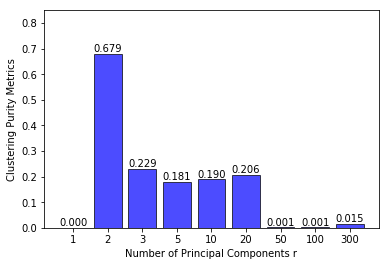

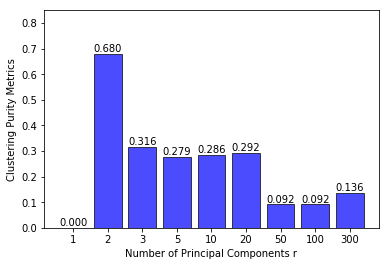

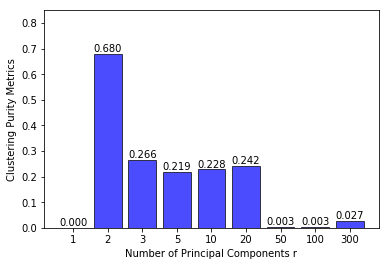

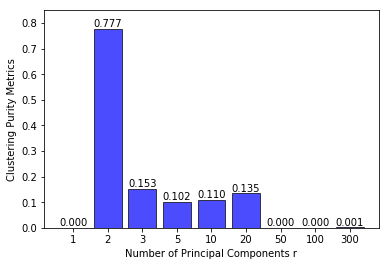

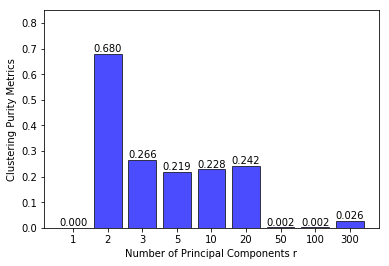

In [12]:
nmf_measure_scores = [(nmf_homogeneity, 'Homogeneity'), (nmf_completeness, 'Completeness'), 
                      (nmf_v_measure, 'V-measure'), (nmf_adjusted_rand_index, 'Adjusted Rand Index'), 
                      (nmf_adjusted_mutual_info, 'Adjusted Mutual Information')]

for score, measure in nmf_measure_scores:
    plot_measurement_score('nmf', measure, score)

## Question 7: Visualization of Clustering Result

In [13]:
def visualize_KMeans_clustering(features, true_labels, method):
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    km.fit(features)
    
    if np.mean(km.labels_ == true_labels) > 0.5:
        predicted_labels = km.labels_
    else:
        predicted_labels = [1-x for x in km.labels_] 
    
    projected_features = features[:,:2]
        
    print("\n===============================================")
    print('Transformation Method: {}'.format(method))
    print("===============================================")
        
    report_clustering_measures(predicted_labels, true_labels)
        
    plt.gcf().clear()
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.scatter(projected_features[:,0], projected_features[:,1], c=predicted_labels, 
                edgecolors='k', linewidth=0.5, cmap=plt.cm.Greys, alpha=0.5)
    plt.title('KMeans Clustering Result', fontweight='bold')
    plt.subplot(1,2,2)
    plt.scatter(projected_features[:,0], projected_features[:,1], c=true_labels,
                edgecolors='k', linewidth=0.5, cmap=plt.cm.Greys, alpha=0.5)
    plt.title('Ground Truth Labels', fontweight='bold')
    plt.tight_layout()
    plt.show()
    #plt.savefig('{}_clustering_viz.png'.format(method))

In [14]:
from scipy import stats

r_best_pca = r_list[stats.mode([np.argmax(pca_homogeneity), np.argmax(pca_homogeneity), np.argmax(pca_homogeneity), 
np.argmax(pca_homogeneity), np.argmax(pca_homogeneity)], axis=None).mode[0]]
r_best_nmf = r_list[stats.mode([np.argmax(nmf_homogeneity), np.argmax(nmf_homogeneity), np.argmax(nmf_homogeneity), 
np.argmax(nmf_homogeneity), np.argmax(nmf_homogeneity)], axis=None).mode[0]]

X_best_pca = TruncatedSVD(n_components=r_best_pca, random_state=42).fit_transform(X_tfidf)
X_best_nmf = NMF(n_components=r_best_nmf, random_state=42).fit_transform(X_tfidf)


Transformation Method: pca
Homogeneity: 0.579310
Completeness: 0.581804
V-measure: 0.580555
Adjusted Rand Index: 0.675433
Adjusted Mutual Information: 0.580516


<Figure size 432x288 with 0 Axes>

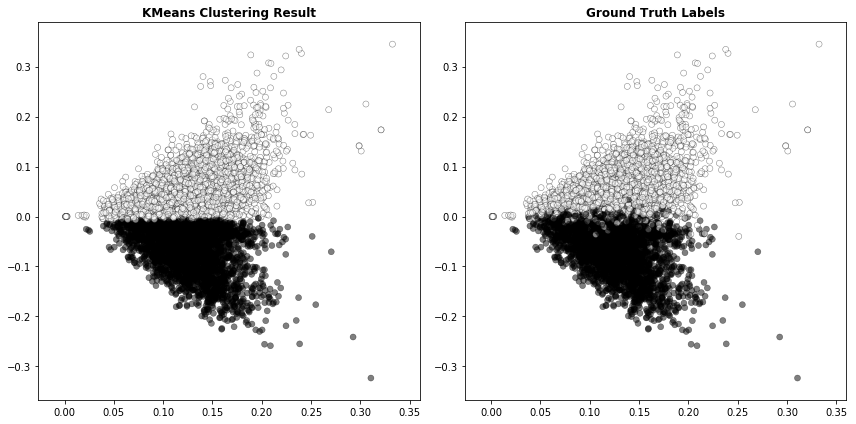


Transformation Method: nmf
Homogeneity: 0.679048
Completeness: 0.680132
V-measure: 0.679590
Adjusted Rand Index: 0.777018
Adjusted Mutual Information: 0.679560


<Figure size 432x288 with 0 Axes>

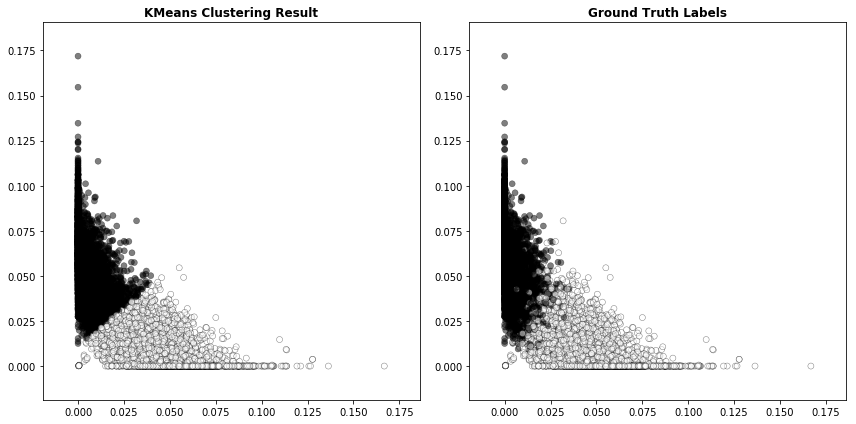

In [15]:
visualize_KMeans_clustering(X_best_pca, labels, 'pca')
visualize_KMeans_clustering(X_best_nmf, labels, 'nmf')

## Question 8-10: Feature Transformation

In [16]:
eps = 10**-3

X_best_pca_standard = np.divide(X_best_pca, np.std(X_best_pca, axis=0))
X_best_nmf_standard = np.divide(X_best_nmf, np.std(X_best_nmf, axis=0))
X_best_nmf_log = np.log(X_best_nmf + eps)
X_best_nmf_standard_log = np.log(X_best_nmf_standard + eps)
X_best_nmf_log_standard = np.divide(X_best_nmf_log, np.std(X_best_nmf_log, axis=0))


Transformation Method: pca
Homogeneity: 0.579310
Completeness: 0.581804
V-measure: 0.580555
Adjusted Rand Index: 0.675433
Adjusted Mutual Information: 0.580516


<Figure size 432x288 with 0 Axes>

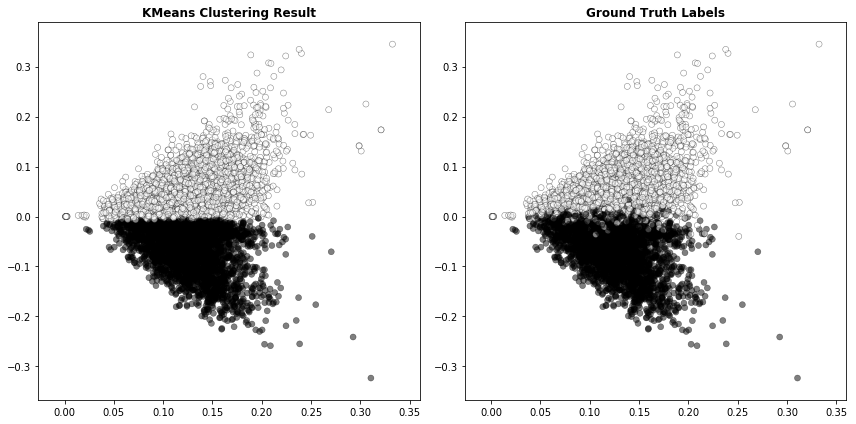


Transformation Method: pca_standard
Homogeneity: 0.235126
Completeness: 0.263639
V-measure: 0.248568
Adjusted Rand Index: 0.254369
Adjusted Mutual Information: 0.248495


<Figure size 432x288 with 0 Axes>

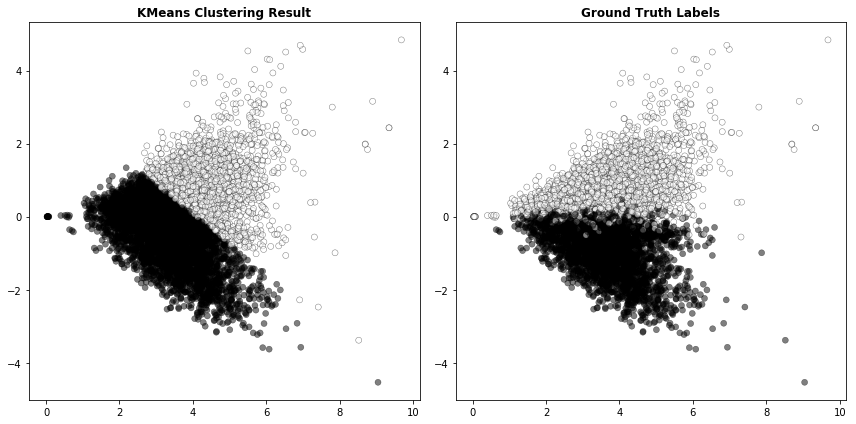


Transformation Method: nmf
Homogeneity: 0.679048
Completeness: 0.680132
V-measure: 0.679590
Adjusted Rand Index: 0.777018
Adjusted Mutual Information: 0.679560


<Figure size 432x288 with 0 Axes>

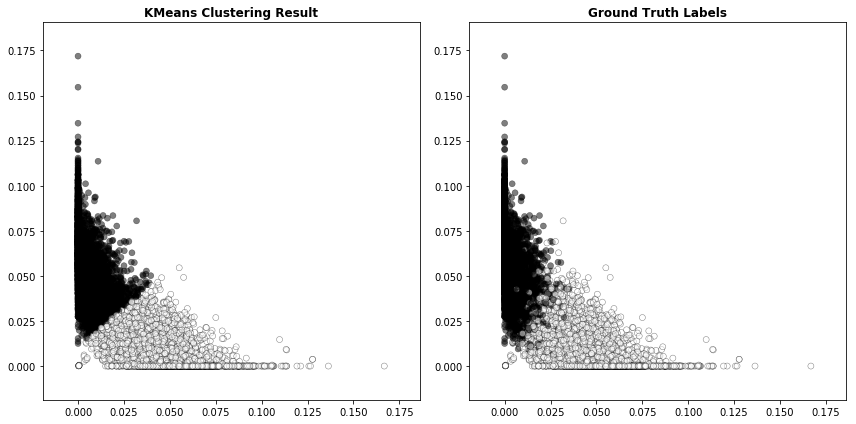


Transformation Method: nmf_standard
Homogeneity: 0.684387
Completeness: 0.687121
V-measure: 0.685751
Adjusted Rand Index: 0.775229
Adjusted Mutual Information: 0.685723


<Figure size 432x288 with 0 Axes>

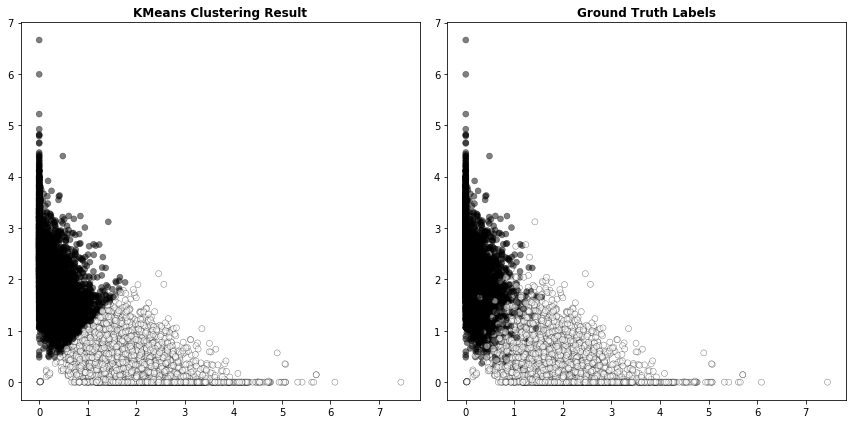


Transformation Method: nmf_standard_log
Homogeneity: 0.193277
Completeness: 0.293192
V-measure: 0.232974
Adjusted Rand Index: 0.109886
Adjusted Mutual Information: 0.232889


<Figure size 432x288 with 0 Axes>

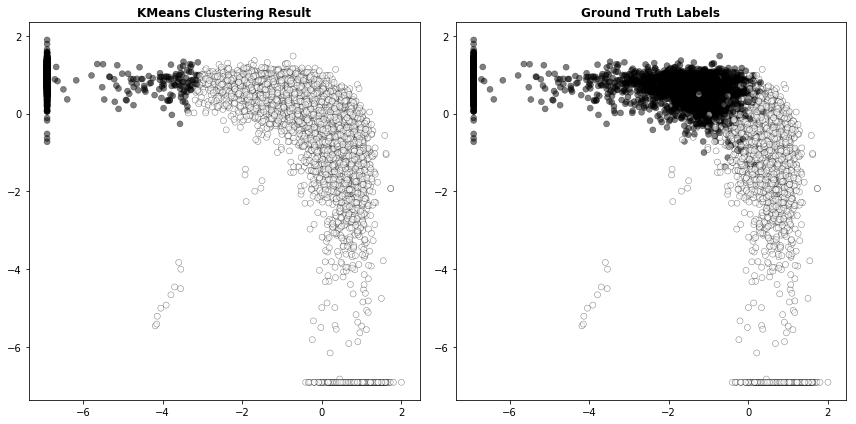


Transformation Method: nmf_log
Homogeneity: 0.712163
Completeness: 0.712273
V-measure: 0.712218
Adjusted Rand Index: 0.808652
Adjusted Mutual Information: 0.712192


<Figure size 432x288 with 0 Axes>

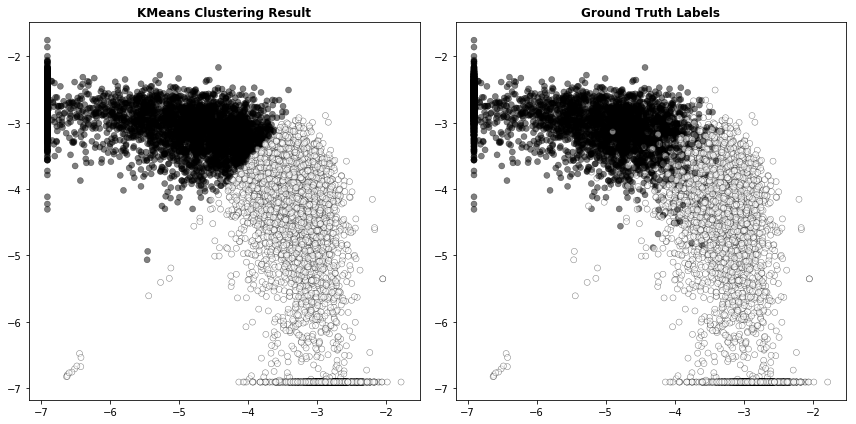


Transformation Method: nmf_log_standard
Homogeneity: 0.710127
Completeness: 0.710852
V-measure: 0.710490
Adjusted Rand Index: 0.805004
Adjusted Mutual Information: 0.710463


<Figure size 432x288 with 0 Axes>

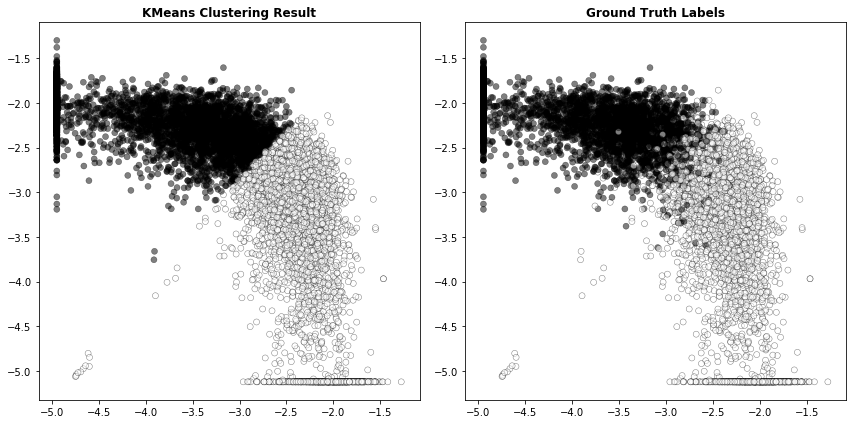

In [17]:
feature_transformations = [(X_best_pca, 'pca'), (X_best_pca_standard, 'pca_standard'), (X_best_nmf, 'nmf'), 
                           (X_best_nmf_standard, 'nmf_standard'), (X_best_nmf_standard_log, 'nmf_standard_log'), 
                           (X_best_nmf_log, 'nmf_log'), (X_best_nmf_log_standard, 'nmf_log_standard')]


for features, method in feature_transformations:
    visualize_KMeans_clustering(features, labels, method)

# Part 2 - Clustering of Your Own Dataset

In [18]:
from sklearn import datasets

digits = datasets.load_digits()
true_k = len(set(digits.target))
km_hwd = KMeans(n_clusters=true_k, init='k-means++', random_state=0, max_iter=1000, n_init=30)
km_hwd.fit(digits.data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=10, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [19]:
contingency_matrix(digits.target, km_hwd.labels_)

array([[  0,   0,   0,   0, 177,   0,   0,   0,   0,   1],
       [  1,   2,  99,   0,   0,   1,  55,   0,  24,   0],
       [  0,   0,   8,   2,   1,  13,   2,   3, 148,   0],
       [  2,   0,   7,  12,   0, 155,   0,   7,   0,   0],
       [  0,   0,   3,   0,   0,   0,   5,   9,   0, 164],
       [136,   1,   0,  42,   0,   1,   0,   0,   0,   2],
       [  0, 177,   2,   0,   1,   0,   1,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   2, 175,   0,   0],
       [  4,   2, 100,  52,   0,   2,   6,   5,   3,   0],
       [  6,   0,   2, 139,   0,   6,  20,   7,   0,   0]])

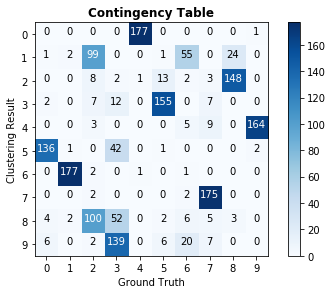

In [20]:
import itertools

def plot_contingency_matrix(label_true, label_pred, classname, normalize=False, title='Contingency Matrix', fs=None):
    plt.figure()
    cmat = contingency_matrix(label_true, label_pred)
    cmap = plt.cm.Blues
    
    if fs is not None:
        plt.figure(figsize=(fs,fs))
    plt.imshow(cmat, interpolation='nearest', cmap=cmap)
    plt.title(title, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(classname))
    plt.xticks(tick_marks, classname)
    plt.yticks(tick_marks, classname)

    if normalize:
        cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]

    # print(cmat)

    thresh = cmat.max() / 2.
    for i, j in itertools.product(range(cmat.shape[0]), range(cmat.shape[1])):
        if normalize == False:
            plt.text(j, i, cmat[i, j], horizontalalignment="center", color="white" if cmat[i, j] > thresh else "black")
        else:
            plt.text(j, i, cmat[i, j], horizontalalignment="center", color="white" if cmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Clustering Result')
    plt.xlabel('Ground Truth')
    plt.show()
    
actual_class_names = ['0','1','2','3','4','5','6','7','8','9']
plot_contingency_matrix(digits.target, km_hwd.labels_, actual_class_names, normalize=False, title='Contingency Table')

In [21]:
report_clustering_measures(km_hwd.labels_, digits.target)

Homogeneity: 0.740193
Completeness: 0.748857
V-measure: 0.744500
Adjusted Rand Index: 0.668689
Adjusted Mutual Information: 0.741927


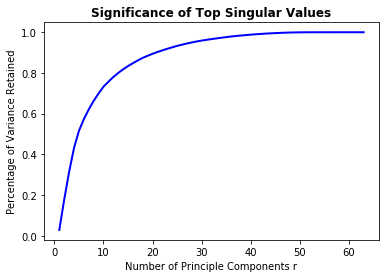

In [22]:
r_max = digits.data.shape[1] - 1
svd = TruncatedSVD(n_components=r_max, random_state=42)
X_svd = svd.fit_transform(digits.data)

variance_percent = [0] * len(svd.explained_variance_ratio_)
for i in range(len(svd.explained_variance_ratio_)):
    variance_percent[i] = sum(svd.explained_variance_ratio_[:i+1])
    
plt.plot(range(1, r_max + 1, 1), variance_percent, linewidth=2, color='b')
plt.xlabel('Number of Principle Components r')
plt.ylabel('Percentage of Variance Retained')
plt.title('Significance of Top Singular Values', fontweight='bold')
plt.show()

In [23]:
def plot_measurement_score_mc(method, measure, scores, r_categories = ['1','2','3','5','10','20','30','40','50','64']):
    fig, ax = plt.subplots()
    
    bars = plt.bar(r_categories, scores, facecolor='blue', alpha = 0.7, edgecolor='black', linewidth=1)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
        
    plt.xticks(r_categories)   
    plt.xlabel('Number of Principal Components r')
    plt.ylabel('Measurement Score')
    plt.title(measure+' Score', fontweight='bold')
    plt.ylim(0,1)
    plt.show()

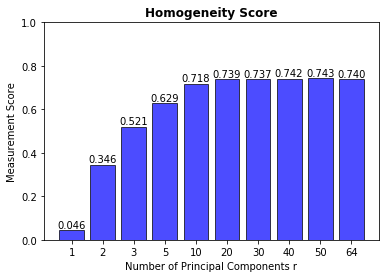

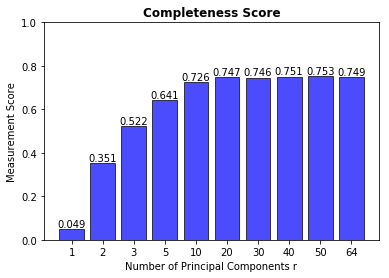

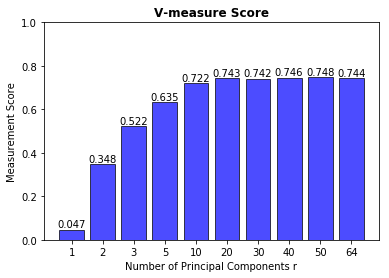

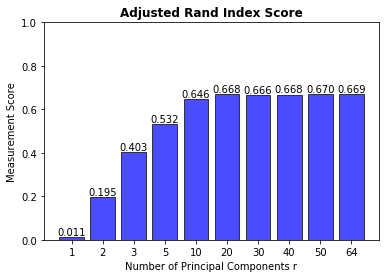

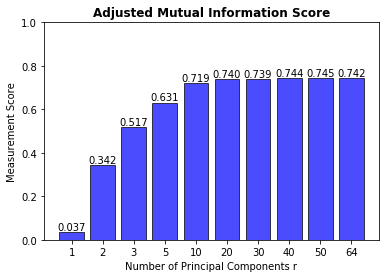

In [24]:
r_list = [1,2,3,5,10,20,30,40,50,64]

pca_homogeneity = []
pca_completeness = []
pca_v_measure = []
pca_adjusted_rand_index = []
pca_adjusted_mutual_info = []

for r in r_list:
    if r == r_max + 1:  
        X_pca = digits.data
    else:
        pca = TruncatedSVD(n_components=r, random_state=42)
        X_pca = pca.fit_transform(digits.data)
    
    km = KMeans(n_clusters=true_k, random_state=0, max_iter=1000, n_init=30)
    km.fit(X_pca)
    
    pca_homogeneity.append(metrics.homogeneity_score(digits.target, km.labels_))
    pca_completeness.append(metrics.completeness_score(digits.target, km.labels_))
    pca_v_measure.append(metrics.v_measure_score(digits.target, km.labels_))
    pca_adjusted_rand_index.append(metrics.adjusted_rand_score(digits.target, km.labels_))
    pca_adjusted_mutual_info.append(metrics.adjusted_mutual_info_score(digits.target, km.labels_))


pca_measure_scores = [(pca_homogeneity, 'Homogeneity'), (pca_completeness, 'Completeness'), 
                      (pca_v_measure, 'V-measure'), (pca_adjusted_rand_index, 'Adjusted Rand Index'), 
                      (pca_adjusted_mutual_info, 'Adjusted Mutual Information')]

for score, measure in pca_measure_scores:
    plot_measurement_score_mc('pca', measure, score)

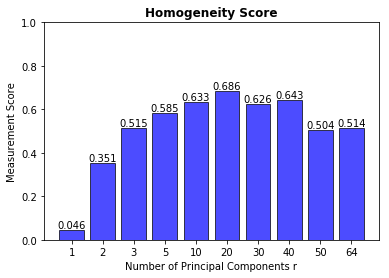

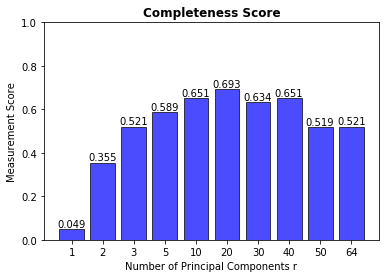

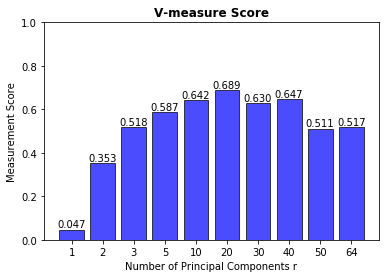

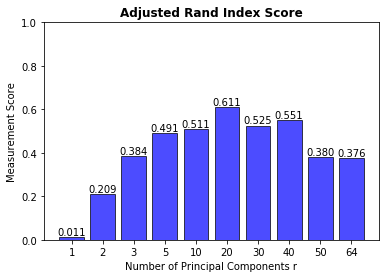

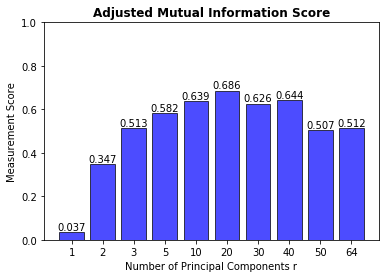

In [25]:
nmf_homogeneity = []
nmf_completeness = []
nmf_v_measure = []
nmf_adjusted_rand_index = []
nmf_adjusted_mutual_info = []

for r in r_list:
    nmf = NMF(n_components=r, random_state=42)
    X_nmf = nmf.fit_transform(digits.data)
    
    km = KMeans(n_clusters=true_k, random_state=0, max_iter=1000, n_init=30)
    km.fit(X_nmf)
    
    nmf_homogeneity.append(metrics.homogeneity_score(digits.target, km.labels_))
    nmf_completeness.append(metrics.completeness_score(digits.target, km.labels_))
    nmf_v_measure.append(metrics.v_measure_score(digits.target, km.labels_))
    nmf_adjusted_rand_index.append(metrics.adjusted_rand_score(digits.target, km.labels_))
    nmf_adjusted_mutual_info.append(metrics.adjusted_mutual_info_score(digits.target, km.labels_))

    
nmf_measure_scores = [(nmf_homogeneity, 'Homogeneity'), (nmf_completeness, 'Completeness'), 
                      (nmf_v_measure, 'V-measure'), (nmf_adjusted_rand_index, 'Adjusted Rand Index'), 
                      (nmf_adjusted_mutual_info, 'Adjusted Mutual Information')]

for score, measure in nmf_measure_scores:
    plot_measurement_score_mc('nmf', measure, score)

In [26]:
def visualize_KMeans_clustering_mc(features, true_labels, method):
    km = KMeans(n_clusters=true_k, random_state=0, max_iter=1000, n_init=30)
    km.fit(features)
     
    class_index = [[] for _ in range(true_k)]
    for i in range(true_k):
        for j in range(len(true_labels)):
            if true_labels[j] == i:
                class_index[i].append(j)
    
    
    class_matrix = [[0] for _ in range(true_k)]
    
    for i in range(true_k):
        cluster_data = [0] * true_k
        for index in class_index[i]:
            cluster_data[km.labels_[index]] += 1 
        class_matrix[i] = [x / sum(cluster_data) for x in cluster_data]
        
    class_matrix = np.array(class_matrix)
    
    cluster_to_class = {}
    for i in range(true_k):   
        cluster_to_class[i] = np.argmax(class_matrix[:,i])
        
    predicted_labels = [0]*len(km.labels_)
    for i in range(len(km.labels_)):
        predicted_labels[i] = cluster_to_class[km.labels_[i]]

        
    if features.shape[1] > 2:
        projected_features = TruncatedSVD(n_components=2, random_state=42).fit_transform(features)
    else:
        projected_features = features
        
    print("\n===============================================")
    print('Transformation Method: {}'.format(method))
    print("===============================================")
    
    report_clustering_measures(predicted_labels, true_labels)
        
    plt.gcf().clear()
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.scatter(projected_features[:,0], projected_features[:,1], c=predicted_labels, 
                edgecolors='k', linewidth=0.5, alpha=0.5)
    plt.title('KMeans Clustering Result', fontweight='bold')
    plt.subplot(1,2,2)
    plt.scatter(projected_features[:,0], projected_features[:,1], c=true_labels,
                edgecolors='k', linewidth=0.5, alpha=0.5)
    plt.title('Ground Truth Labels', fontweight='bold')
    plt.tight_layout()
    plt.show()


Transformation Method: pca
Homogeneity: 0.743449
Completeness: 0.752538
V-measure: 0.747966
Adjusted Rand Index: 0.669565
Adjusted Mutual Information: 0.745427


<Figure size 432x288 with 0 Axes>

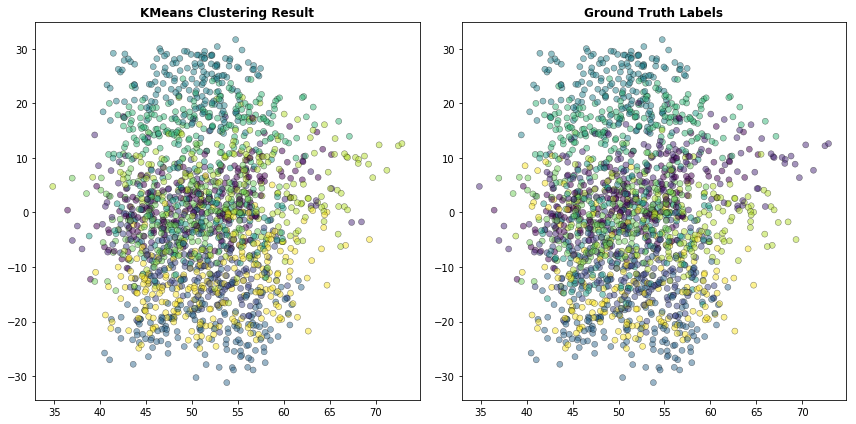


Transformation Method: nmf
Homogeneity: 0.680106
Completeness: 0.717197
V-measure: 0.698159
Adjusted Rand Index: 0.624762
Adjusted Mutual Information: 0.695409


<Figure size 432x288 with 0 Axes>

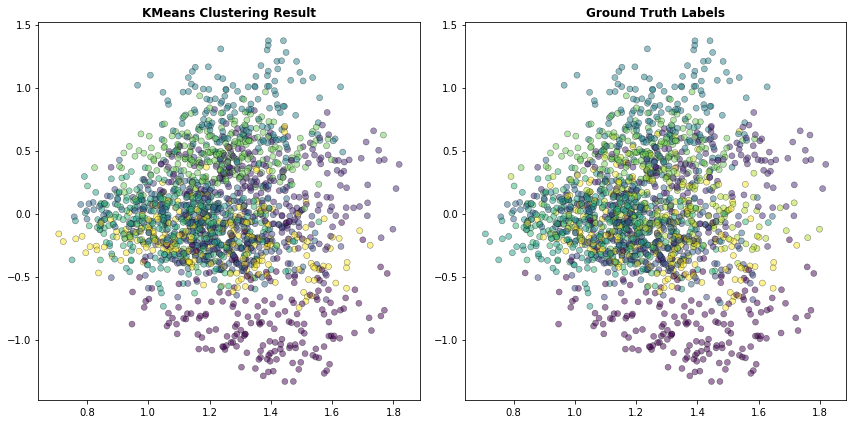

In [27]:
r_best_pca = r_list[stats.mode([np.argmax(pca_homogeneity), np.argmax(pca_homogeneity), np.argmax(pca_homogeneity), 
np.argmax(pca_homogeneity), np.argmax(pca_homogeneity)], axis=None).mode[0]]
r_best_nmf = r_list[stats.mode([np.argmax(nmf_homogeneity), np.argmax(nmf_homogeneity), np.argmax(nmf_homogeneity), 
np.argmax(nmf_homogeneity), np.argmax(nmf_homogeneity)], axis=None).mode[0]]

X_best_pca = TruncatedSVD(n_components=r_best_pca, random_state=42).fit_transform(digits.data)
X_best_nmf = NMF(n_components=r_best_nmf, random_state=42).fit_transform(digits.data)

visualize_KMeans_clustering_mc(X_best_pca, digits.target, 'pca')
visualize_KMeans_clustering_mc(X_best_nmf, digits.target, 'nmf')


Transformation Method: pca
Homogeneity: 0.743449
Completeness: 0.752538
V-measure: 0.747966
Adjusted Rand Index: 0.669565
Adjusted Mutual Information: 0.745427


<Figure size 432x288 with 0 Axes>

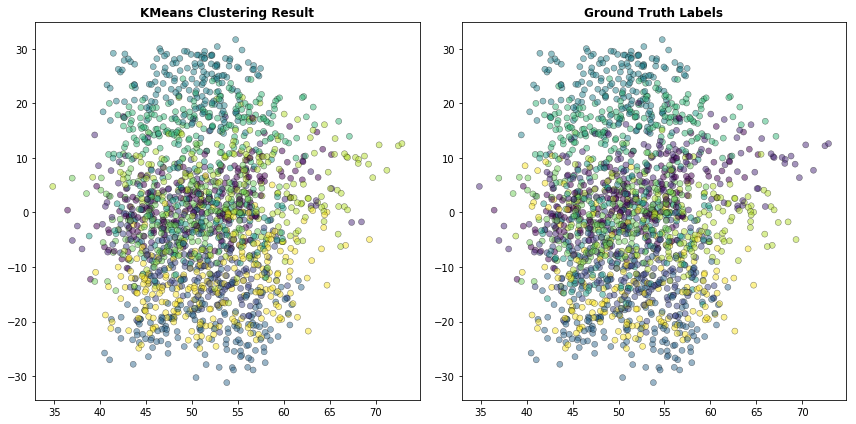


Transformation Method: pca_standard
Homogeneity: 0.626784
Completeness: 0.697702
V-measure: 0.660344
Adjusted Rand Index: 0.515613
Adjusted Mutual Information: 0.657149


<Figure size 432x288 with 0 Axes>

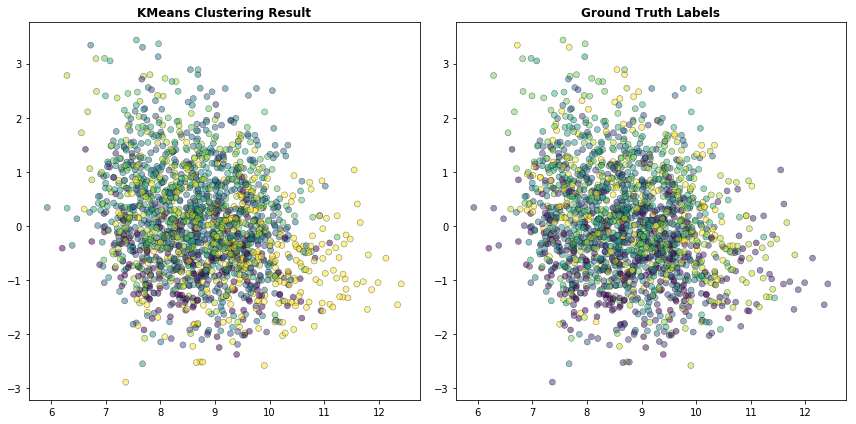


Transformation Method: nmf
Homogeneity: 0.680106
Completeness: 0.717197
V-measure: 0.698159
Adjusted Rand Index: 0.624762
Adjusted Mutual Information: 0.695409


<Figure size 432x288 with 0 Axes>

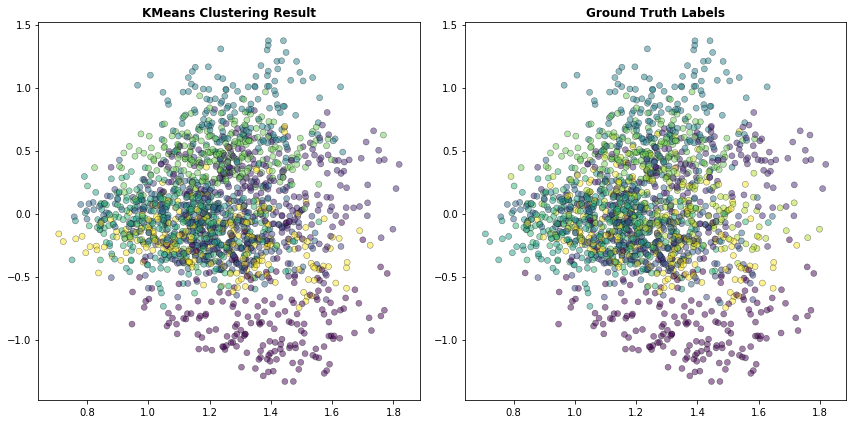


Transformation Method: nmf_standard
Homogeneity: 0.714956
Completeness: 0.755814
V-measure: 0.734818
Adjusted Rand Index: 0.653812
Adjusted Mutual Information: 0.732398


<Figure size 432x288 with 0 Axes>

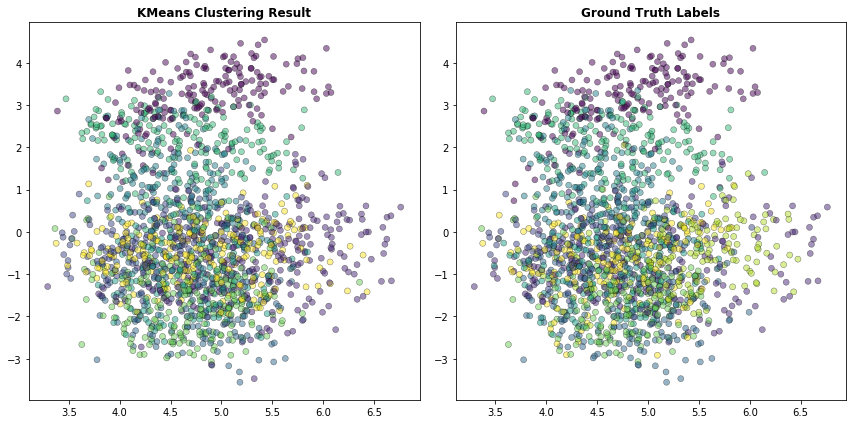


Transformation Method: nmf_standard_log
Homogeneity: 0.657063
Completeness: 0.703704
V-measure: 0.679584
Adjusted Rand Index: 0.566321
Adjusted Mutual Information: 0.676640


<Figure size 432x288 with 0 Axes>

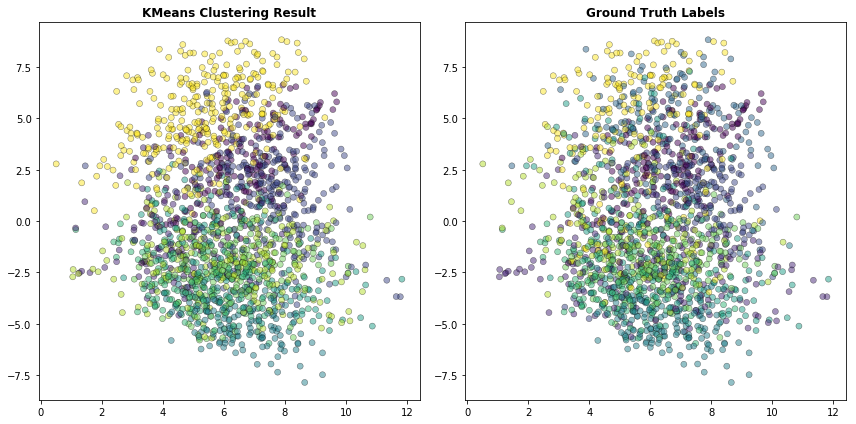


Transformation Method: nmf_log
Homogeneity: 0.709976
Completeness: 0.718279
V-measure: 0.714103
Adjusted Rand Index: 0.634026
Adjusted Mutual Information: 0.711224


<Figure size 432x288 with 0 Axes>

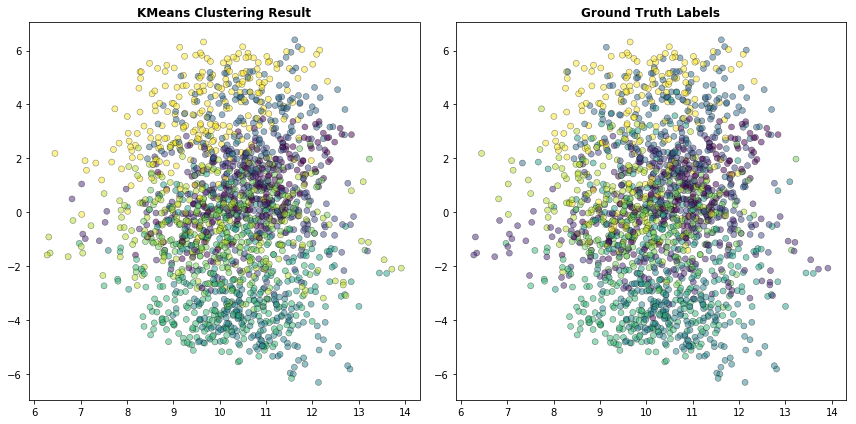


Transformation Method: nmf_log_standard
Homogeneity: 0.720051
Completeness: 0.727576
V-measure: 0.723794
Adjusted Rand Index: 0.644727
Adjusted Mutual Information: 0.721014


<Figure size 432x288 with 0 Axes>

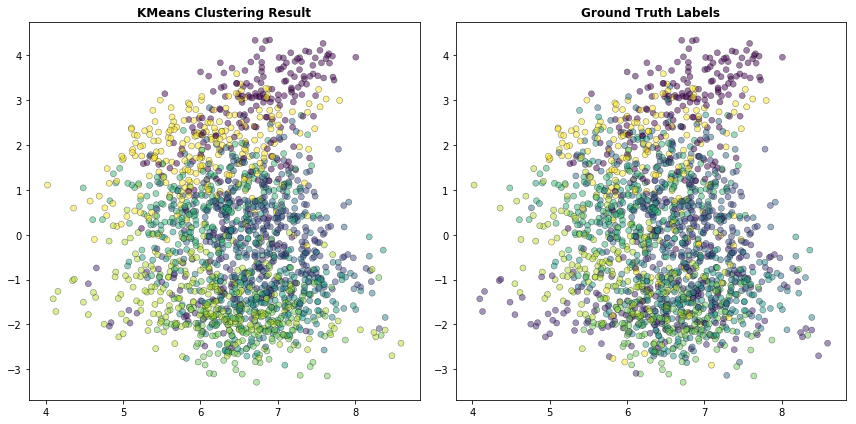

In [28]:
eps = 10**-2

X_best_pca_standard = np.divide(X_best_pca, np.std(X_best_pca, axis=0))
X_best_nmf_standard = np.divide(X_best_nmf, np.std(X_best_nmf, axis=0))
X_best_nmf_log = np.log(X_best_nmf + eps)
X_best_nmf_standard_log = np.log(X_best_nmf_standard + eps)
X_best_nmf_log_standard = np.divide(X_best_nmf_log, np.std(X_best_nmf_log, axis=0))


feature_transformations = [(X_best_pca, 'pca'), (X_best_pca_standard, 'pca_standard'), (X_best_nmf, 'nmf'), 
                           (X_best_nmf_standard, 'nmf_standard'), (X_best_nmf_standard_log, 'nmf_standard_log'), 
                           (X_best_nmf_log, 'nmf_log'), (X_best_nmf_log_standard, 'nmf_log_standard')]


for features, method in feature_transformations:
    visualize_KMeans_clustering_mc(features, digits.target, method)

# Part 3 - Color Clustering

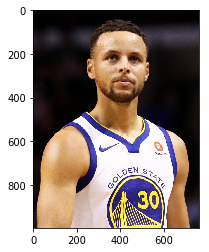

In [29]:
from matplotlib import image

data = image.imread('stephen_curry.jpg')
plt.imshow(data)
plt.show()

In [30]:
data_reshape = data.reshape((-1, 3))
data_normalized = data_reshape / (data_reshape.sum(axis=1).reshape((-1,1)) + 10**-15)
data_rg_normalized = data_normalized[:,:2]

In [31]:
def find_optimal_k(image, k):
    km = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30)
    km.fit(image)
    
    segmentation = km.labels_.reshape((data.shape[0], data.shape[1]))
    plt.imshow(segmentation)
    plt.show()

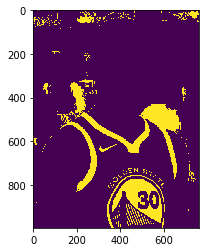

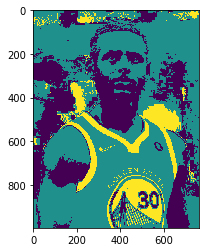

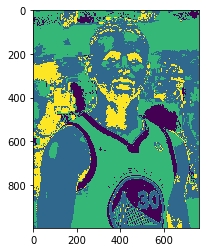

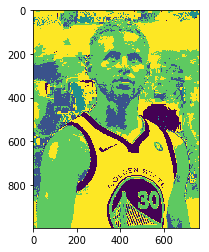

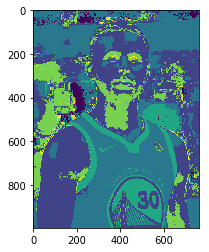

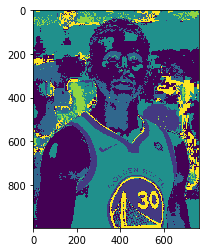

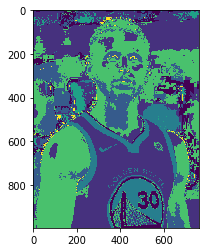

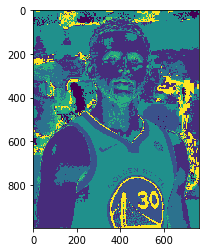

In [32]:
for k in range(2, 10):
    find_optimal_k(data_rg_normalized, k)

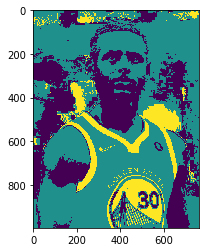

In [33]:
km_best = KMeans(n_clusters=3, random_state=0, max_iter=1000, n_init=30).fit(data_rg_normalized)
image_segmentation = km_best.labels_.reshape((data.shape[0], data.shape[1]))
plt.imshow(image_segmentation)
plt.show()
# image.imsave('stephen_curry_seg.png', image_segmentation)